<a href="https://colab.research.google.com/github/giuliovv/ANNDL_competition_1/blob/master/competition_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

colab = "True" #@param ['True','False']
if colab == "True":
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/Colab Notebooks
  if not os.path.isdir('training'):
    !unzip dataset.zip

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab Notebooks


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
dataset_dir = 'training'

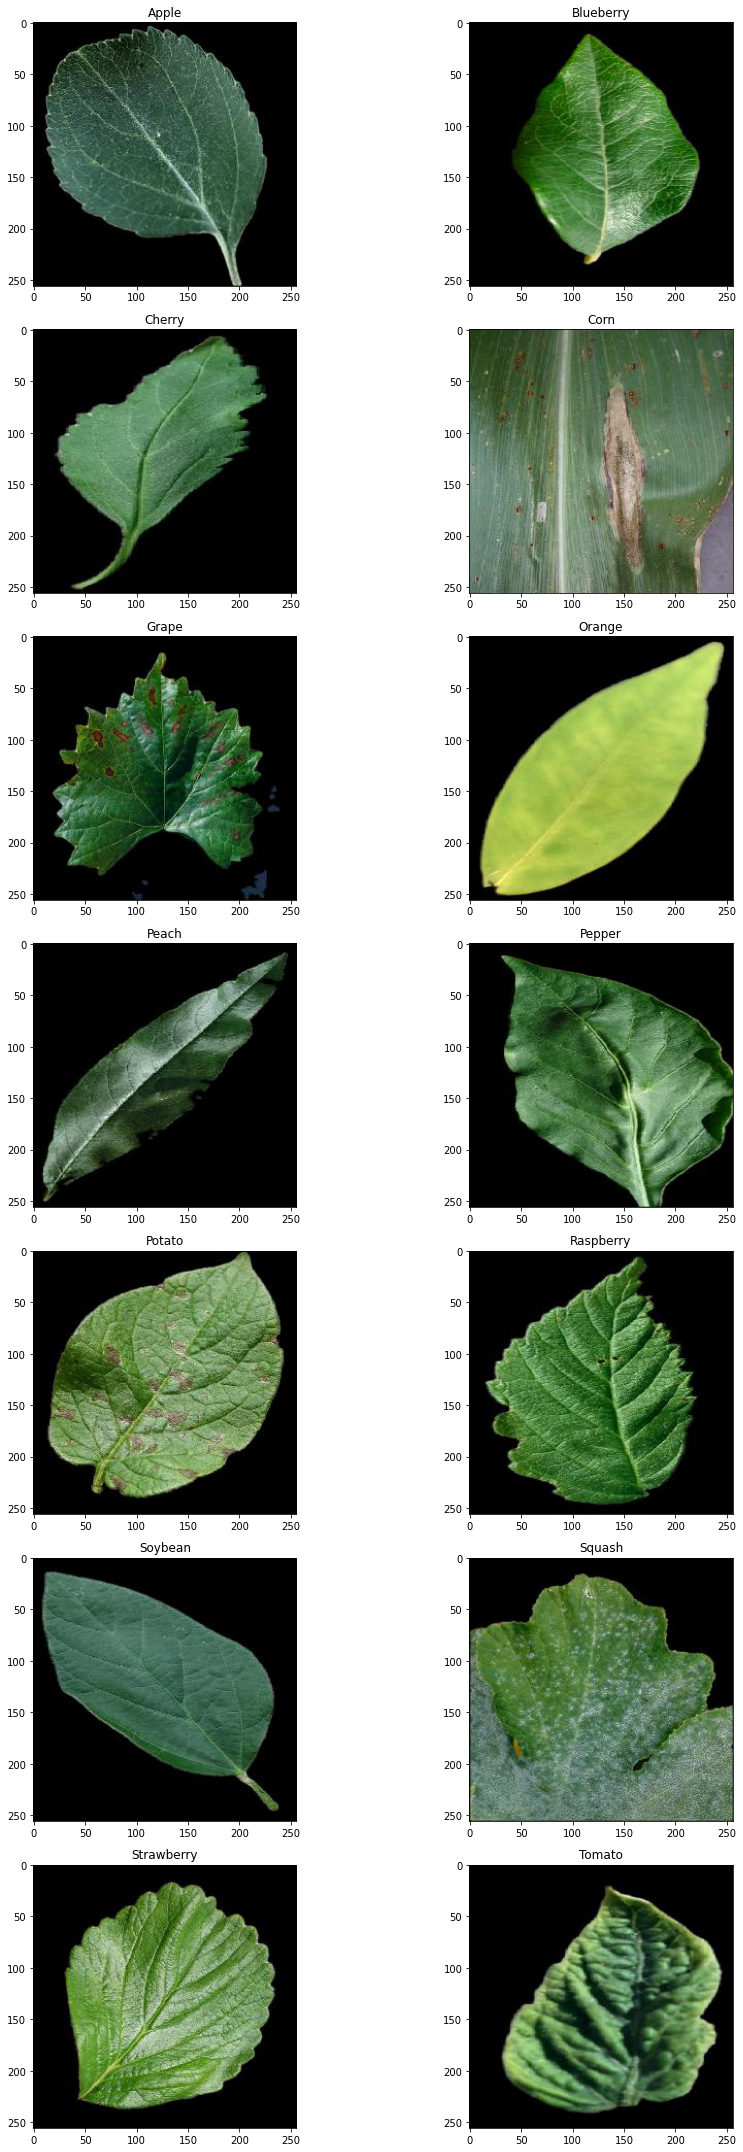

In [4]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Let the game begin

In [5]:
import tensorflow as tf

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
y = tf.keras.utils.to_categorical(range(len(labels)))
y

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
      dtype=float32)

In [9]:
# I forgot to convert to RGB but no errors where thown so maybe it's already RGB?
if not "X.npy" in os.listdir():
  import cv2
  X_data = []
  y_data = []
  for i, label in enumerate(labels):
    print(label)
    for pic in os.listdir("training/"+label):
      img = np.array(Image.open('{}/{}/{}'.format(dataset_dir, label, pic)))
      # There are 2 samples with double resolution
      if img.shape != (256, 256, 3):
        # There is one sample entirely black
        if img.shape == (256, 256):
          continue 
        img = cv2.resize(img, (256, 256))
      X_data.append(img)
      y_data.append(y[i])
  print("Ok, saving...")
  X = np.array(X_data)
  y = np.array(y_data)
  with open("X.npy", "wb") as f:
    np.save(f, X)
  with open("y.npy", "wb") as f:
    np.save(f, y)
else:
  print("Loading X...")
  X = np.load("X.npy", allow_pickle=True)
  print("Loading y...")
  y = np.load("y.npy", allow_pickle=True)

Loading X...
Loading y...


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

In [11]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [12]:
n_classes = len(labels)

In [13]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have n_classes classes
predictions = Dense(n_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [14]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.experimental.BackupAndRestore(
    "top_only"
)

In [ ]:
# train the model on the new data for a few epochs
model.fit(X_train, y_train, epochs=1, batch_size=8, validation_data=(X_val, y_val), callbacks=[callback])

 462/1790 [======>.......................] - ETA: 30:56 - loss: 8.9874 - accuracy: 0.3747

In [ ]:
model.save("inception3_only_top")

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

callback = tf.keras.callbacks.experimental.BackupAndRestore(
    "second_part"
)

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(X_train, y_train, epochs=4, batch_size=16, validation_data=(X_val, y_val), callbacks=[callback])

In [ ]:
model.save("inception3")

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)

In [ ]:
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
matrix.diagonal()/matrix.sum(axis=1)

In [ ]:
tf.keras.backend.mean(tf.keras.backend.equal(tf.keras.backend.argmax(y_test, axis=-1), tf.keras.backend.argmax(y_pred, axis=-1))).numpy()